<a href="https://colab.research.google.com/github/tejaspradhan/Graph-Neural-Networks/blob/main/personality-analysis-project/Personality_Analysis_One_Hot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U tf_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from tf_geometric.utils import tf_utils

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import pandas as pd
from collections import Counter

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# # In case of any corpus are missing 
# download all-nltk
nltk.download('stopwords')
stop_words = stopwords.words("english")

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
import tensorflow as tf
import tf_geometric as tfg
import pickle
import re

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.

In [3]:
data = pd.read_csv('/content/mbti_cleaned.csv')

In [4]:
data.head()

,Unnamed: 0,type,Number of posts,Posts
0,0,INFJ,50,intj moments sportscenter plays pra...
1,1,ENTP,50,finding lack these posts very alarmingsex...
2,2,INTP,50,good course which know thats blessi...
3,3,INTJ,50,dear intp enjoyed conversation other es...
4,4,ENTJ,50,youre firedthats another silly misconception t...


In [5]:
posts = np.array(data['Posts'])
posts.astype(np.dtype('str'))
data['Posts']

0         intj moments    sportscenter    plays    pra...
1        finding  lack    these posts very alarmingsex...
2       good       course  which    know thats  blessi...
3       dear intp    enjoyed  conversation  other   es...
4       youre firedthats another silly misconception t...
                              ...                        
7582     just because  always think  cats   doms  some...
7583    soif this thread already exists someplace else...
7584     many questions when   these things   would ta...
7585      very conflicted right  when  comes  wanting ...
7586      been  long since  have been  personalitycafe...
Name: Posts, Length: 7587, dtype: object

In [6]:
data['type'].unique().shape[0] # 16 different personalities

16

In [7]:
data.isna().sum()

Unnamed: 0          0
type                0
Number of posts     0
Posts              42
dtype: int64

In [8]:
data.dropna(inplace=True)

In [9]:
texts = data['Posts']

In [10]:
isE, isN, isT, isJ = [],[],[],[]
for t in data['type']:
  isE.append(1) if t[0]=='E' else isE.append(0)
  isN.append(1) if t[1]=='N' else isN.append(0)
  isT.append(1) if t[2]=='T' else isT.append(0)
  isJ.append(1) if t[3]=='J' else isJ.append(0)

In [11]:
data['isE'], data['isN'], data['isT'],data['isJ'] = isE, isN, isT, isJ
data.head()

,Unnamed: 0,type,Number of posts,Posts,isE,isN,isT,isJ
0,0,INFJ,50,intj moments sportscenter plays pra...,0,1,0,1
1,1,ENTP,50,finding lack these posts very alarmingsex...,1,1,1,0
2,2,INTP,50,good course which know thats blessi...,0,1,1,0
3,3,INTJ,50,dear intp enjoyed conversation other es...,0,1,1,1
4,4,ENTJ,50,youre firedthats another silly misconception t...,1,1,1,1


In [12]:
labels= np.array(data[['isE','isN','isT','isJ']])

In [13]:
labels.shape

(7545, 4)

In [14]:
texts = texts.astype('string')

In [15]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.3)

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts[:254])
tokenizer.fit_on_texts(train_texts[256:])

In [17]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [18]:
train_labels.shape

(5281, 4)

In [19]:
class PMIModel(object):

    def __init__(self):
        self.word_counter = None
        self.pair_counter = None

    def get_pair_id(self, word0, word1):
        pair_id = tuple(sorted([word0, word1]))
        return pair_id

    def fit(self, sequences, window_size):

        self.word_counter = Counter()
        self.pair_counter = Counter()
        num_windows = 0
        for sequence in tqdm(sequences):
            for offset in range(len(sequence) - window_size):
                window = sequence[offset:offset + window_size]
                num_windows += 1
                for i, word0 in enumerate(window):
                    self.word_counter[word0] += 1
                    for j, word1 in enumerate(window[i + 1:]):
                        pair_id = self.get_pair_id(word0, word1)
                        self.pair_counter[pair_id] += 1

        for word, count in self.word_counter.items():
            self.word_counter[word] = count / num_windows
        for pair_id, count in self.pair_counter.items():
            self.pair_counter[pair_id] = count / num_windows

    def transform(self, word0, word1):
        prob_a = self.word_counter[word0]
        prob_b = self.word_counter[word1]
        pair_id = self.get_pair_id(word0, word1)
        prob_pair = self.pair_counter[pair_id]

        if prob_a == 0 or prob_b == 0 or prob_pair == 0:
            return 0

        pmi = np.log(prob_pair / (prob_a * prob_b))
        # print(word0, word1, pmi)
        pmi = np.maximum(pmi, 0.0)
        # print(pmi)
        return pmi

In [20]:
def build_word_graph(num_words, pmi_model, embedding_size):
    x = tf.Variable(tf.random.truncated_normal([num_words, embedding_size], stddev=1 / np.sqrt(embedding_size)),
                    dtype=tf.float32)
    edges = []
    edge_weight = []
    for (word0, word1) in pmi_model.pair_counter.keys():
        pmi = pmi_model.transform(word0, word1)
        if pmi > 0:
            edges.append([word0, word1])
            edge_weight.append(pmi)
            edges.append([word1, word0])
            edge_weight.append(pmi)
    edge_index = np.array(edges).T
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)

In [21]:
def build_combined_graph(word_graph, sequences, embedding_size):
    num_words = word_graph.num_nodes
    x = tf.zeros([len(sequences), embedding_size], dtype=tf.float32)
    edges = []
    edge_weight = []
    for i, sequence in enumerate(sequences):
        doc_node_index = num_words + i
        for word in sequence:
            edges.append([doc_node_index, word])  # only directed edge
            edge_weight.append(1.0)  # use BOW instaead of TF-IDF

    edge_index = np.array(edges).T
    x = tf.concat([word_graph.x, x], axis=0)
    edge_index = np.concatenate([word_graph.edge_index, edge_index], axis=1)
    edge_weight = np.concatenate([word_graph.edge_weight, edge_weight], axis=0)
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)

In [22]:
pmi_cache_path = "cached_pmi_model.p"
if os.path.exists(pmi_cache_path):
    with open(pmi_cache_path, "rb") as f:
        pmi_model = pickle.load(f)
else:
    pmi_model = PMIModel()
    pmi_model.fit(train_sequences, window_size=6)
    with open(pmi_cache_path, "wb") as f:
        pickle.dump(pmi_model, f)

embedding_size = 150
num_words = len(tokenizer.word_index) + 1
word_graph = build_word_graph(num_words, pmi_model, embedding_size)
train_combined_graph = build_combined_graph(word_graph, train_sequences, embedding_size)
test_combined_graph = build_combined_graph(word_graph, test_sequences, embedding_size)

print(word_graph)
print(train_combined_graph)
print(test_combined_graph)

num_classes = 4

Graph Shape: x => (165627, 150)	edge_index => (2, 8533206)	y => None
Graph Shape: x => (170908, 150)	edge_index => (2, 11255093)	y => None
Graph Shape: x => (167891, 150)	edge_index => (2, 9652226)	y => None


In [23]:
print(train_combined_graph)
print(test_combined_graph)

Graph Shape: x => (170908, 150)	edge_index => (2, 11255093)	y => None
Graph Shape: x => (167891, 150)	edge_index => (2, 9652226)	y => None


In [24]:
class GCNModel(tf.keras.Model):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gcn0 = tfg.layers.GCN(32, activation=tf.nn.relu)
        self.gcn1 = tfg.layers.GCN(32,activation = tf.nn.relu)
        self.gcn2 = tfg.layers.GCN(64,activation = tf.nn.relu)
        self.gcn3 = tfg.layers.GCN(num_classes, activation = tf.nn.softmax)
        self.dropout = keras.layers.Dropout(0.5)

    def call(self, inputs, training=None, mask=None, cache=None):
        x, edge_index, edge_weight = inputs
        h = self.gcn0([x, edge_index, edge_weight], cache=cache)
        h = self.gcn1([h, edge_index, edge_weight],cache=cache)
        h = self.dropout(h, training=training);
        h = self.gcn2([h, edge_index, edge_weight],cache=cache)
        h = self.gcn3([h, edge_index, edge_weight], cache=cache)
        return h

In [25]:
model = GCNModel()
model.gcn0.cache_normed_edge(train_combined_graph)
model.gcn0.cache_normed_edge(test_combined_graph)

/usr/local/lib/python3.7/dist-packages/tf_geometric/layers/conv/gcn.py:79: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead", DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/tf_geometric/layers/conv/gcn.py:79: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead", DeprecationWarning)


In [26]:
@tf_utils.function
def forward(graph, training=False):
    logits = model([graph.x, graph.edge_index, graph.edge_weight], cache=graph.cache, training=training)
    logits = logits[num_words:]
    return logits

In [27]:
def compute_loss(logits, labels):
    losses = tf.keras.losses.categorical_crossentropy(labels, logits)
    mean_loss = tf.reduce_mean(losses)
    return mean_loss

In [36]:
optimizer = tf.keras.optimizers.Adam(lr=0.05)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
import numpy as np

def hamming_score(y_pred, y_true):
    y_pred = np.array(y_pred).astype(int)
    print("AND", (y_true & y_pred).sum(axis=1))
    print("OR", (y_true | y_pred).sum(axis=1))
    
    return (
        (y_true & y_pred).sum(axis=1) / (y_true | y_pred).sum(axis=1)
    ).mean()

In [ ]:
train_losses =[]
test_losses = []

In [37]:
for step in range(1000):
    with tf.GradientTape() as tape:
        logits = forward(train_combined_graph, training=True)
        # print("logits" ,logits[0],"Shape",logits[0].shape)
        mean_loss = compute_loss(logits, train_labels)
        print(f"Step : {step} loss: {mean_loss} ")
        train_losses.append(mean_loss)
    vars = tape.watched_variables()
    grads = tape.gradient(mean_loss, vars)
    optimizer.apply_gradients(zip(grads, vars))

    if step % 10 == 0:
        # train accuracytf.one_hot(labels, depth=num_classes)
        # print(logits)
        # print(f"Step : {step}  --- Accuracy : {hamming_score(logits,train_labels)}")
        # corrects = tf.cast(tf.equal(preds, train_labels), tf.float32)
        # train_accuracy = tf.reduce_mean(corrects)

        logits = forward(test_combined_graph)
        test_loss = compute_loss(logits, test_labels)
        test_losses.append(test_loss)
        print(f"Step: {step} Test loss: {test_loss} ")
        # preds = tf.argmax(logits, axis=-1)
        # corrects = tf.cast(tf.equal(preds, test_labels), tf.float32)
        # accuracy = tf.reduce_mean(corrects)
        # print("step = {}\tloss = {}\ttrain_accuracy = {}\ttest_accuracy = {}".format(step, mean_loss, train_accuracy,accuracy))

Step : 0 loss: 2.402754783630371 
Step: 0 Test loss: 4.7660298347473145 
Step : 1 loss: 4.712532043457031 
Step : 2 loss: 2.5451786518096924 
Step : 3 loss: 2.4760849475860596 
Step : 4 loss: 2.5107805728912354 
Step : 5 loss: 2.491997480392456 
Step : 6 loss: 2.470268726348877 
Step : 7 loss: 2.4597079753875732 
Step : 8 loss: 2.455385684967041 
Step : 9 loss: 2.4533727169036865 
Step : 10 loss: 2.451387405395508 
Step: 10 Test loss: 2.5226008892059326 
Step : 11 loss: 2.448957681655884 
Step : 12 loss: 2.4456424713134766 
Step : 13 loss: 2.442314624786377 
Step : 14 loss: 2.4393627643585205 
Step : 15 loss: 2.436056613922119 
Step : 16 loss: 2.4350802898406982 
Step : 17 loss: 2.433056116104126 
Step : 18 loss: 2.4336369037628174 
Step : 19 loss: 2.432088613510132 
Step : 20 loss: 2.431105852127075 
Step: 20 Test loss: 2.542985200881958 
Step : 21 loss: 2.4306209087371826 
Step : 22 loss: 2.430349588394165 
Step : 23 loss: 2.4290826320648193 
Step : 24 loss: 2.4277515411376953 
Step 

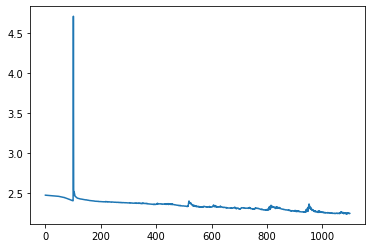

In [38]:
import matplotlib.pyplot as plt 
plt.plot(range(len(train_losses)),train_losses)
plt.show()

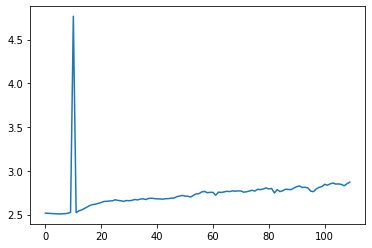

In [39]:
plt.plot(range(len(test_losses)),test_losses)